In [1]:
# Dependencies
# ! pip install fastai nbdev sentencepiece
# ! pip install fastai --upgrade
# ! pip install nltk


In [1]:
# imports
import re
import sentencepiece as sp
from fastai.text import *
import warnings
from pathlib import Path
import sentencepiece as spm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import json
import pandas as pd
warnings.simplefilter("ignore", UserWarning)  #no UserWarning display

Train Dataframe Loading

In [2]:
code_file = "Data1/data_round_1/train/train.token.code" 
nl_file = "Data1/data_round_1/train/train.token.nl"
ast_file = "Data1/data_round_1/train/train.token.ast" 

with open(code_file, "r", encoding="utf-8") as f_code, open(nl_file, "r", encoding="utf-8") as f_nl, open(ast_file, "r", encoding="utf-8") as f_ast:
    code_lines = f_code.readlines()
    nl_lines = f_nl.readlines()
    ast_lines = f_ast.readlines()

assert len(code_lines) == len(nl_lines), "Mismatch in the number of lines between code and nl files"
df_trn = pd.DataFrame({"code": [line.strip() for line in code_lines], 
                   "comment": [line.strip() for line in nl_lines],
                    "ast": [line.strip() for line in ast_lines]})

In [3]:
df_trn.head()

,code,comment,ast
0,private Environment . Frame createGlobals ( Ev...,create native global variables from the module...,( MethodDeclaration ( ReferenceType ( Referenc...
1,"private boolean boundsSafe ( int x , int y ) {...",just a simple check to see if the x y pair act...,( MethodDeclaration ( BasicType ) BasicType ( ...
2,private ResourceResponse patchResourceById ( C...,patches the given resource and will also remov...,( MethodDeclaration ( ReferenceType ) Referenc...
3,private void zoomOut ( ) { chartView . zoomOut...,to zoom out .,( MethodDeclaration ( StatementExpression ( Me...
4,public CombinedRangeXYPlot ( ValueAxis rangeAx...,creates a new plot .,( ConstructorDeclaration ( FormalParameter ( R...


Test and Valid Dataframe loading

In [4]:
test_code_file = "Data1/data_round_1/test/test.token.code"  # Update the path
test_nl_file = "Data1/data_round_1/test/test.token.nl"      # Update the path

with open(test_code_file, "r", encoding="utf-8") as f_code, open(test_nl_file, "r", encoding="utf-8") as f_nl:
    test_code_lines = f_code.readlines()
    test_nl_lines = f_nl.readlines()

# assert len(code_lines) == len(nl_lines), "Mismatch in the number of lines between code and nl files"
df_tst = pd.DataFrame({"code": [line.strip() for line in test_code_lines], 
                   "comment": [line.strip() for line in test_nl_lines]})

In [5]:
df_tst.head()

,code,comment
0,"public int entrySize ( Object key , Object val...",as far as we re concerned all entries have the...
1,private void returnData ( Object ret ) { if ( ...,used to communicate a return object from a plu...
2,public CModuleFilterFieldMenu ( final JTextFie...,creates a new menu object .
3,private void returnData ( Object ret ) { if ( ...,used to communicate a return object from a plu...
4,public TLongArrayList ( ) { this ( DEFAULT_CAP...,creates a new tlongarraylist instance with the...


In [6]:
val_code_file = "Data1/data_round_1/valid/valid.token.code"  # Update the path
val_nl_file = "Data1/data_round_1/valid/valid.token.nl"      # Update the path

with open(val_code_file, "r", encoding="utf-8") as f_code, open(val_nl_file, "r", encoding="utf-8") as f_nl:
    val_code_lines = f_code.readlines()
    val_nl_lines = f_nl.readlines()

# assert len(code_lines) == len(nl_lines), "Mismatch in the number of lines between code and nl files"
df_val = pd.DataFrame({"code": [line.strip() for line in val_code_lines], 
                   "comment": [line.strip() for line in val_nl_lines]})

In [7]:
df_val.head()

,code,comment
0,public void makeCurrent ( EGLSurface eglSurfac...,makes our egl context current using the suppli...
1,public BigFractionFormat ( ) { },create an improper formatting instance with th...
2,public static void main ( final String [ ] arg...,runs this test from the command line .
3,"@ DSGenerator ( tool_name = STR_ , tool_versio...",is memory file purging enabled ?
4,public JoinAppGroupDialog ( final Activity act...,constructs a joinappgroupdialog .


Cleaning

In [8]:
def isASCII(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [9]:
df_trn = df_trn[df_trn['comment'].apply(lambda x: isASCII(x))]
df_val = df_val[df_val['comment'].apply(lambda x: isASCII(x))]
df_tst = df_tst[df_tst['comment'].apply(lambda x: isASCII(x))]

In [11]:
# def filter_jdocs(df):
#     methods = []
#     comments = []
#     for i, row in progress_bar(list(df.iterrows())):
#         comment = row["comment"]
#         # Remove {} text in comments from https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
#         comment = re.sub("([\{\[]).*?([\)\}])", '', comment)
#         cleaned = []
#         for line in comment.split('\n'):
#             if "@" in line: break
#             cleaned.append(line)
#         comments.append('\n'.join(cleaned))
#         methods.append(row["code"])
#     new_df = pd.DataFrame(zip(methods, comments), columns = ["code", "comment"])
    # return new_df

In [10]:
len(df_trn), len(df_val), len(df_tst)

(445812, 20000, 20000)

Train  a tokenizer model

In [11]:
merged_text_file = "code.txt"
with open(r"Data1/data_round_1/train/train.token.code", "r", encoding="utf-8") as code_file, \
     open(merged_text_file, "w", encoding="utf-8") as merged_file:
    for code in code_file:
        merged_file.write(code.strip() + "\n")

In [12]:
merged_text_file = "comments.txt"
with open(r"Data1/data_round_1/train/train.token.nl", "r", encoding="utf-8") as nl_file, \
     open(merged_text_file, "w", encoding="utf-8") as merged_file:
    for nl in nl_file:
        merged_file.write(nl.strip() + "\n")

In [13]:
merged_text_file = "asts.txt"
with open(r"Data1/data_round_1/train/train.token.ast", "r", encoding="utf-8") as ast_file, \
     open(merged_text_file, "w", encoding="utf-8") as merged_file:
    for ast in ast_file:
        merged_file.write(ast.strip() + "\n")

In [14]:
import sentencepiece as spm
spm.SentencePieceTrainer.train(
    input="code.txt",  # Input file
    model_prefix="method_tokenizer",  # Output file prefix (creates tokenizer.model & tokenizer.vocab)
    vocab_size=32000,  # Adjust as needed
    character_coverage=1.0,  # Covers all characters
    model_type="unigram"  # Other options: bpe, char, word
)

In [17]:
spm.SentencePieceTrainer.train(
    input="comments.txt",  # Input file
    model_prefix="comment_tokenizer",  # Output file prefix (creates tokenizer.model & tokenizer.vocab)
    vocab_size=26000,  # Adjust as needed
    character_coverage=1.0,  # Covers all characters
    model_type="unigram"  # Other options: bpe, char, word
)

In [ ]:
spm.SentencePieceTrainer.train(
    input="asts.txt",  # Input file
    model_prefix="ast_tokenizer",  # Output file prefix (creates tokenizer.model & tokenizer.vocab)
    vocab_size=26000,  # Adjust as needed
    character_coverage=1.0,  # Covers all characters
    model_type="unigram"  # Other options: bpe, char, word
)

Tokenization Part

In [18]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [ ]:
# #collapse_show
# def seq2seq_collate(samples, pad_idx=1):
#     """Custom collate function for padding sequences."""
#     if len(samples) == 0: return None
#     x, y = zip(*samples)
#     x_pad = pad_sequence([tensor(o) for o in x], padding_value=pad_idx, batch_first=True)
#     y_pad = pad_sequence([tensor(o) for o in y], padding_value=pad_idx, batch_first=True)
#     return x_pad, y_pad

# class Seq2SeqDataBunch(TextDataBunch):
#     "Create a `TextDataBunch` suitable for training an RNN classifier."
#     @classmethod
#     def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
#                dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
#         "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
#         datasets = cls._init_ds(train_ds, valid_ds, test_ds)
#         val_bs = ifnone(val_bs, bs)
#         collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
#         train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
#         train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
#         dataloaders = [train_dl]
#         for ds in datasets[1:]:
#             lengths = [len(t) for t in ds.x.items]
#             sampler = SortSampler(ds.x, key=lengths.__getitem__)
#             dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
#         return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

# class Seq2SeqTextList(TextList):
#     _bunch = Seq2SeqDataBunch
#     _label_cls = TextList

In [ ]:
method_tokenizer_path = Path("method_tokenizer.model")  
comment_tokenizer_path = Path("comment_tokenizer.model")
ast_tokenizer_path = Path("ast_tokenizer.model")
method_processor = spm.SentencePieceProcessor(model_file=str(method_tokenizer_path))
comment_processor = spm.SentencePieceProcessor(model_file=str(comment_tokenizer_path))
ast_processor = spm.SentencePieceProcessor(model_file=str(ast_tokenizer_path))

In [21]:
# def gen_dbs(df_trn, df_val, df_tst, spm_model_path, bs=96, max_seq=128):
#     # Merge training and validation datasets with a 'valid' column
#     df_merged = pd.concat([df_trn.assign(valid=False), df_val.assign(valid=True)])

#     # Load SentencePiece tokenizer from trained model
#     method_tok = SentencePieceTokenizer(sp_model=spm_model_path)
#     comment_tok = SentencePieceTokenizer(sp_model=spm_model_path)

#     # Define DataBlock for training
#     dblock = DataBlock(
#         blocks=(TextBlock.from_df("code", tok=method_tok),
#                 TextBlock.from_df("comment", tok=comment_tok)),
#         get_x=ColReader("code"),
#         get_y=ColReader("comment"),
#         splitter=ColSplitter("valid"),
#         n_inp=1
#     )

#     # Load DataLoaders
#     db_trn = dblock.dataloaders(df_merged, bs=bs)

#     # Define DataBlock for test set
#     dblock_test = DataBlock(
#         blocks=(TextBlock.from_df("code", tok=method_tok),
#                 TextBlock.from_df("comment", tok=comment_tok)),
#         get_x=ColReader("code"),
#         get_y=ColReader("comment"),
#         splitter=FuncSplitter(lambda x: False),  # No validation split for test
#         n_inp=1
#     )

#     db_tst = dblock_test.dataloaders(df_tst, bs=16)

#     return db_trn, db_tst

In [ ]:
method_sp = spm.SentencePieceProcessor()
method_sp.load("method_tokenizer.model")
comment_sp = spm.SentencePieceProcessor()
comment_sp.load("comment_tokenizer.model")
ast_sp = spm.SentencePieceProcessor()
ast_sp.load("ast_tokenizer.model")

True

In [ ]:
df_trn["code"] = df_trn["code"].apply(lambda x: " ".join(method_sp.encode_as_pieces(x)))
df_trn["comment"] = df_trn["comment"].apply(lambda x: " ".join(comment_sp.encode_as_pieces(x)))
df_trn["ast"] = df_trn["ast"].apply(lambda x: " ".join(ast_sp.encode_as_pieces(x)))

In [32]:
from fastai.text.all import *

dblock = DataBlock(
    blocks=(TextBlock.from_df("code_tok"), TextBlock.from_df("comment_tok")),
    get_x=ColReader("code_tok"),
    get_y=ColReader("comment_tok"),
    splitter=RandomSplitter(valid_pct=0.2),  # FIXED: Random splitting instead of 'valid' column
    n_inp=1
)


In [26]:
# db_trn = dblock.dataloaders(df_trn, bs=96, num_workers=0)

In [ ]:
method_sp = spm.SentencePieceProcessor()
method_sp.load("method_tokenizer.model")

comment_sp = spm.SentencePieceProcessor()
comment_sp.load("comment_tokenizer.model")

ast_sp = spm.SentencePieceProcessor()
ast_sp.load("ast_tokenizer.model")

# Tokenize the dataset
df_trn["code"] = df_trn["code"].apply(lambda x: method_sp.encode_as_ids(x))
df_trn["comment"] = df_trn["comment"].apply(lambda x: comment_sp.encode_as_ids(x))
df_trn["ast"] = df_trn["ast"].apply(lambda x: comment_sp.encode_as_ids(x))

In [36]:
df_trn.head()

,code,comment,ast
0,"[43, 3, 1067, 3, 31999, 3, 570, 80, 3, 12818, 3, 4, 3, 4863, 14943, 3, 8, 3, 450, 465, 3, 8, 3, 9617, 4132, 3, 5, 3, 9, 3, 1067, 851, 10, 80, 3, 1067, 3, 4, 14943, 3, 8, 3, 1067, 3, 31999, 3, 14425, 3, 292, 3, 754, 3, 6660, 341, 3, 8, 5204, 3, 71, 3, 31999, 22, 18, 3, 8, 3, 1035, 3, 31997, 888, 3, 4, 3, 5, 3, 5, 3, 6, 44, 3, 4, 364, 22, 3, 69, 3, 31997, 899, 3, 42, 4129, 3, 5, 3, 9, 267, 3, 31999, 109, 3, ...]","[32, 705, 844, 493, 20, 4, 2137, 4, 548, 24, 89, 33, 3552, 12, 717, 667, 7, 7538, 3]","[46, 0, 46, 0, 209, 46, 15190, 46, 0, 209, 3747, 5, 8826, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 36, 16444, 46, 0, 5, ...]"
1,"[43, 34, 1090, 3, 638, 3, 4, 19, 62, 3, 8, 19, 102, 3, 5, 3, 9, 16, 3, 4, 3, 4, 102, 22, 15, 3, 7, 3, 5, 111, 111, 3, 4, 102, 3, 31997, 10, 317, 3, 5, 111, 111, 3, 4, 62, 22, 15, 3, 7, 3, 5, 111, 111, 3, 4, 62, 3, 31997, 10, 301, 3, 5, 3, 5, 3, 9, 14, 30, 3, 7, 3, 6, 3, 31998, 14, 30, 3, 7, 3, 6, 3, 31998]","[412, 5, 387, 77, 6, 353, 19, 4, 161, 323, 472, 527, 46, 179, 3256, 54, 4, 1651, 40, 3]","[46, 0, 46, 0, 209, 46, 15190, 46, 0, 209, 3747, 5, 8826, 46, 0, 46, 0, 14920, 46, 0, 323, 6171, 46, 0, 46, 0, 14920, 46, 0, 323, 6171, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 14920, 46, 0, 323, 6171, 46, 0, 46, 0, 14920, 46, 0, 323, 6171, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 14920, 46, 0, 323, 6171, 46, 0, 46, 0, 14920, 46, ...]"
2,"[43, 3, 16118, 2303, 3, 356, 3, 3543, 3, 4, 3, 105, 104, 3, 8, 3, 153, 152, 3, 8, 18, 2956, 3, 8, 18, 5664, 3, 8, 139, 22, 3, 2354, 3, 373, 3, 31997, 2303, 3, 1487, 3, 5, 36, 3, 356, 3, 29, 3, 9, 150, 3, 1669, 3, 4, 152, 3, 31999, 1717, 3, 156, 3, 4, 3, 5, 3, 5, 3, 6, 1900, 3, 1042, 3, 1046, 3, 4, 152, 3, 31999, 1717, 3, 156, 3, 4, 3, 5, 3, 5, 3, 6, 3, 16118, 540, 10, 168, 3, 356, 3, 4, 104, 3, 8, ...]","[1163, 209, 61, 4, 18, 247, 10, 78, 912, 145, 690, 296, 19, 37, 11, 13, 704, 134, 135, 1634, 206, 3]","[46, 0, 46, 0, 209, 46, 15190, 46, 0, 209, 3747, 5, 8826, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 209, 46, 10517, ...]"
3,"[43, 23, 18133, 3, 4, 3, 5, 3, 9, 2372, 3, 155, 3, 31999, 18133, 3, 4, 3, 5, 3, 6, 3172, 3, 5352, 3, 31999, 6257, 3, 3113, 3, 289, 3, 334, 3, 4, 2372, 3, 155, 3, 31999, 1109, 3, 3113, 3, 289, 3, 4, 3, 5, 3, 5, 3, 6, 3172, 3, 5352, 3, 31999, 6257, 3, 25901, 3, 334, 3, 4, 2372, 3, 155, 3, 31999, 1109, 3, 25901, 3, 4, 3, 5, 3, 5, 3, 6, 3, 31998]","[6, 1164, 193, 3]","[46, 0, 46, 0, 209, 46, 15190, 46, 0, 209, 3747, 5, 8826, 46, 0, 46, 0, 46, 17028, 46, 0, 6034, 46, 14087, 46, 0, 46, 0, 209, 46, 15190, 46, 0, 261, 1741, 443, 1524, 46, 0, 46, 0, 209, 46, 15190, 46, 0, 261, 1741, 443, 1524, 46, 0, 46, 0, 46, 17028, 46, 0, 6034, 46, 14087, 46, 0, 46, 0, 46, 17028, 46, 0, 6034, 46, 14087, 46, 0, 46, 0, 209, 46, 15190, 46, 0, 261, 1741, 443, 1524, 46, 0, 46, 0, 209, 46, 15190, 46, 0, 261, 1741, 443, 1524, 46, 0, ...]"
4,"[12, 3, 11094, 3, 495, 3, 10864, 3, 4, 13933, 11068, 3, 5, 3, 9, 57, 3, 4, 20, 3, 8, 20, 3, 8, 11068, 3, 8, 20, 3, 5, 3, 6, 26, 3, 31999, 9528, 3, 27, 10, 17, 193, 3, 31999, 706, 3, 31999, 195, 22, 3, 10864, 3, 31997, 3, 4, 3, 5, 3, 6, 3, 31998]","[21, 5, 17, 1461, 3]","[46, 0, 46, 0, 35, 2746, 878, 46, 0, 209, 3747, 5, 8826, 46, 0, 46, 0, 36, 16444, 46, 0, 5, 421, 5, 6471, 46, 0, 46, 0, 209, 46, 10517, 46, 0, 323, 6171, 46, 0, 

In [37]:
class CodeCommentDataset(Dataset):
    def __init__(self, df):
        self.codes = df["code"].tolist()
        self.comments = df["comment"].tolist()

    def __len__(self):
        return len(self.codes)

    def __getitem__(self, idx):
        return torch.tensor(self.codes[idx]), torch.tensor(self.comments[idx])

# Create dataset instances
train_dataset = CodeCommentDataset(df_trn)

In [38]:
#  For padding purposes
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)  # Unzip source and target sequences
    src_batch = pad_sequence([torch.tensor(x) for x in src_batch], batch_first=True, padding_value=1)  # PAD_IDX=1
    tgt_batch = pad_sequence([torch.tensor(x) for x in tgt_batch], batch_first=True, padding_value=1)
    return src_batch, tgt_batch

In [39]:
BATCH_SIZE = 32 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=None)

In [40]:
train_dataset

Defining Model

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import corpus_bleu

In [42]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.outer(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = nn.Embedding(vocab_sz, emb_sz)  # Fix embedding call
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop:
        layers.append(nn.Dropout(ff_p))
    
    return nn.Sequential(
        *layers,
        nn.Linear(d_ff, d_model),
        nn.Dropout(ff_p),
        nn.LayerNorm(d_model)  # Removed `MergeLayer()`
    )


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = d_head if d_head is not None else d_model // n_heads  # Fix d_head
        
        self.n_heads, self.d_head, self.scale = n_heads, d_head, scale
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att, self.drop_res = nn.Dropout(p), nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs, seq_len = q.size(0), q.size(1)
        wq, wk, wv = map(lambda o: self.create_attn_mat(*o, bs), zip((q, kv, kv), (self.q_wgt, self.k_wgt, self.v_wgt)))
        
        attn_score = wq @ wk.transpose(2, 3)
        if self.scale:
            attn_score /= math.sqrt(self.d_head)
        if mask is not None:
            attn_score = attn_score.masked_fill(mask.bool(), float('-inf'))  # Fix mask handling
        
        attn_prob = self.drop_att(nn.functional.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)


def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None, None].bool()


class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [43]:
class Transformer(nn.Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        super().__init__()  # Initialize nn.Module properly
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.0)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight  # Weight tying
        self.pad_idx = pad_idx

    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)  # Ensure this function exists
        enc, out = self.enc_emb(inp), self.dec_emb(out)
        for layer in self.encoder:
            enc = layer(enc)  # Apply each encoder layer sequentiall
        for layer in self.decoder:
            out = layer(out, enc, mask_out)  # Decoder processes input & encoded output
        return self.out(out)

In [ ]:
from fastai.callback.core import Callback
# For Evaluation Purposes
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [45]:
inp_vocab_size = len(df_trn["code"].tolist())  # Adjust based on preprocessing
out_vocab_size = len(df_trn["comment"].tolist())

model = Transformer(inp_vocab_size, out_vocab_size, d_model=256)

In [46]:
def collate_fn(batch):
    src, tgt = zip(*batch)  # Unzip the batch into source and target sequences

    # Convert to tensors
    src = [torch.tensor(seq, dtype=torch.long) for seq in src]
    tgt = [torch.tensor(seq, dtype=torch.long) for seq in tgt]

    # Pad sequences to the maximum length in the batch
    src_padded = pad_sequence(src, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt, batch_first=True, padding_value=0)

    return src_padded, tgt_padded

# Update DataLoader
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # Your dataset object
    batch_size=32,  # Adjust batch size as needed
    shuffle=True,
    collate_fn=collate_fn  # Use custom collate function
)

In [47]:
with open("tokenizer.vocab", "r", encoding="utf-8") as f:
    vocab = [line.strip() for line in f.readlines()]

VOCAB_SIZE = len(vocab)
print(f"Vocabulary Size: {VOCAB_SIZE}")


Vocabulary Size: 32000


Training

In [48]:
VOCAB_SIZE = 32000
LR = 3e-4
EPOCHS = 8
model_name = "comment_gen"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
print(model)

Transformer(
  (enc_emb): TransformerEmbedding(
    (embed): Embedding(445812, 256)
    (pos_enc): PositionalEncoding()
    (drop): Dropout(p=0.1, inplace=False)
  )
  (dec_emb): TransformerEmbedding(
    (embed): Embedding(445812, 256)
    (pos_enc): PositionalEncoding()
    (drop): Dropout(p=0.0, inplace=False)
  )
  (encoder): ModuleList(
    (0-5): 6 x EncoderBlock(
      (mha): MultiHeadAttention(
        (q_wgt): Linear(in_features=256, out_features=256, bias=True)
        (k_wgt): Linear(in_features=256, out_features=256, bias=True)
        (v_wgt): Linear(in_features=256, out_features=256, bias=True)
        (out): Linear(in_features=256, out_features=256, bias=True)
        (drop_att): Dropout(p=0.1, inplace=False)
        (drop_res): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, i

In [50]:
def train_model(learn, epochs, model_name, max_lr = 5e-4):
    """Trains a model using save model, early stopping, and show graph call backs."""
    callback_fns = [
        callbacks.SaveModelCallback(
            learn, every='improvement',
            monitor='valid_loss', name=f'{model_name}_save_model'
        ),
        callbacks.EarlyStoppingCallback(
            learn, monitor='valid_loss', min_delta = 0.01,
            patience = 3
        ),
        ShowGraph(learn)
    ]

    learn.fit_one_cycle(epochs, max_lr, div_factor=5, callbacks = callback_fns)

   epoch  train_loss  valid_loss  accuracy      bleu   time
0      0    1.182219    1.133453  0.828182  0.791774  25:46
1      1    0.920205    0.954264  0.841556  0.799681  25:47
2      2    0.812330    0.875513  0.849487  0.804000  23:44
3      3    0.752023    0.828835  0.853668  0.807183  23:45
4      4    0.679716    0.794862  0.856593  0.809325  24:43
5      5    0.653454    0.777795  0.859418  0.811010  25:42
6      6    0.611860    0.770059  0.860419  0.812164  25:49
7      7    0.605370    0.769881  0.860601  0.812119  24:45

Better model found at epoch 0 with valid_loss value: 1.133453130722046.
Better model found at epoch 1 with valid_loss value: 0.9542644023895264.
Better model found at epoch 2 with valid_loss value: 0.8755126595497131.
Better model found at epoch 3 with valid_loss value: 0.8288350701332092.
Better model found at epoch 4 with valid_loss value: 0.7948615550994873.
Better model found at epoch 5 with valid_loss value: 0.7777946591377258.
Better model found at 

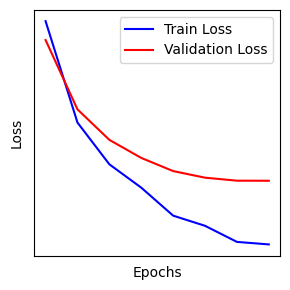

In [ ]:
train_model(model, EPOCHS, model_name)

In [ ]:
torch.save(model.state_dict(), "fine_tuned_code_comment_model")
print("Model saved successfully!")

Model saved successfully!


In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Define the path to your saved model
model_path = r"E:\Prasad\NLP\testing\fine_tuned_code_comment_model"

# Load the fine-tuned model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [2]:
code_snippet = "private boolean boundsSafe ( int x , int y ) { if ( ( y < NUM_ ) || ( y >= height ) || ( x < NUM_ ) || ( x >= width ) ) { return BOOL_ ; } return BOOL_ ; }"

# Tokenize input
inputs = tokenizer(code_snippet, return_tensors="pt", padding=True, truncation=True)

# Generate prediction
output = model.generate(**inputs)

# Decode output
generated_comment = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Comment:", generated_comment)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generated Comment: Just a simple check to see if the x , y pair actually fits into the array .


In [58]:
len(df_tst)

20000

In [ ]:
def generate_comment(code_snippet):
    """Generate a comment for the given code snippet using the model."""
    inputs = tokenizer(code_snippet, return_tensors="pt", padding=True, truncation=True)
    output = model.generate(**inputs)
    return tokenizer.decode(output[0], skip_special_tokens=True)

def calculate_bleu(df):
    """
    Calculate BLEU score for the test DataFrame.
    :param df: DataFrame containing 'code' and 'comment' columns
    :return: BLEU score
    """
    references = [[ref.split()] for ref in df["comment"].tolist()]  # Convert references into tokenized lists
    candidates = [generate_comment(code).split() for code in df["code"].tolist()]  # Generate comments and tokenize
    
    bleu_score = corpus_bleu(references, candidates)
    return bleu_score

# Compute BLEU score
bleu = calculate_bleu(df_tst)
print(f"BLEU Score: {bleu:.4f}")


BLEU Score: 0.4681


In [64]:
! pip install textstat

   ---------------------------------------- 0.0/939.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/939.4 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/939.4 kB 1.7 MB/s eta 0:00:01
   --------------------------------- ------ 786.4/939.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 939.4/939.4 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   --------------- ------------------------ 0.8/2.1 MB 1.2 MB/s eta 0:00:02
   -------------------- ------------------- 1.0/2.1 MB 1.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.1 MB 1.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.1 MB 1.2 MB/s eta 0:00:01
   ----------------------------------- ---- 1.8/2.1 MB 1.2 MB/s eta 0:00:01
   --------------------------


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import textstat

def calculate_readability(df):
    """
    Calculate readability scores for the generated comments.
    :param df: DataFrame containing 'code' and 'comment' columns
    :return: Average readability scores (Flesch Reading Ease, Flesch-Kincaid Grade Level)
    """
    generated_comments = [generate_comment(code) for code in df["code"].tolist()]

    # Compute readability scores
    flesch_scores = [textstat.flesch_reading_ease(comment) for comment in generated_comments]
    flesch_kincaid_scores = [textstat.flesch_kincaid_grade(comment) for comment in generated_comments]

    # Average scores
    avg_flesch_score = sum(flesch_scores) / len(flesch_scores)
    avg_flesch_kincaid = sum(flesch_kincaid_scores) / len(flesch_kincaid_scores)

    return avg_flesch_score, avg_flesch_kincaid

# Compute Readability Score
avg_flesch, avg_flesch_kincaid = calculate_readability(df_tst)

print(f"Average Flesch Reading Ease Score: {avg_flesch:.2f}")
print(f"Average Flesch-Kincaid Grade Level: {avg_flesch_kincaid:.2f}")


Average Flesch Reading Ease Score: 56.67
Average Flesch-Kincaid Grade Level: 7.59
